In [29]:
import pandas as pd
import numpy as np
import os
import scipy
from scipy import stats
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import time
from datetime import datetime
%matplotlib inline


In [30]:
%run ./asm00_fitting_functions.ipynb

# reading in

In [32]:
d_pplu = pd.read_csv("ppluGFP_cdf_fitting_20200329-084353.csv.gz")
d_amac = pd.read_csv("amacGFP_cdf_fitting_20200329-021058.csv.gz")
d_cgre = pd.read_csv("cgreGFP_cdf_fitting_20200329-061344.csv.gz")

d_pplu_AB = pd.read_csv("ppluGFP_cdf_fitting_AB_20200329-084353.csv.gz")
d_amac_AB = pd.read_csv("amacGFP_cdf_fitting_AB_20200329-021058.csv.gz")
d_cgre_AB = pd.read_csv("cgreGFP_cdf_fitting_AB_20200329-061344.csv.gz")

# linear regression 

In [38]:
def AB_relation(d):
    slope, intercept, r_value, p_value, std_err = stats.linregress(d.A_mu,d.B_mu)
    return dict(zip(['slope', 'intercept', 'r_value', 'p_value', 'std_err'],[slope, intercept, r_value, p_value, std_err ]))


In [58]:
bc_controls

{'av': ['ACCCCAAGCAAAAACAGCCG',
  'AAACCAGTAAATGAAAAACA',
  'ACCCCCCAATCCCCCACCTC',
  'CTCCACTATAACACAATCAC'],
 'amac': ['CTTTCCGACGCTATATCCCC', 'CTTTTACTGTGTGTAATTTT'],
 'cgre': ['AACCCACGCCCCCATTTTTT',
  'TTCCCCCCCGCCCCATTCCT',
  'AATTTCCTCTTTACTTCATA',
  'ACCTCACATCTTCTGACTTT'],
 'pplu': ['CCCCGCCCTCTTACATGCCT', 'CCACCATATCCACACCCCCA'],
 'count': ['CCAGCACCACCAAAGCATGA',
  'ACTCGCACTTTCGAAACCCA',
  'CTCCCCCCTAGCAATCCACC',
  'AACCCCCAAAAGAAAAACCC',
  'TCTAATTACAAAACAATTCC']}

In [ ]:
inrange_wt_barcodes =[]
for wt in ['av','amac','pplu']:
    inrange_wt_barcodes.extend(bc_controls[wt])

In [42]:
cgre_regress = AB_relation(d_cgre_AB[d_cgre_AB.primary_bc.isin(inrange_wt_barcodes)])
amac_regress = AB_relation(d_amac_AB[d_amac_AB.primary_bc.isin(inrange_wt_barcodes)])
pplu_regress = AB_relation(d_pplu_AB[d_pplu_AB.primary_bc.isin(inrange_wt_barcodes)])

In [48]:
cgre_regress['POI']='cgreGFP'
amac_regress['POI']='amacGFP'
pplu_regress['POI']='ppluGFP'

regress_df = pd.DataFrame.from_records([cgre_regress,amac_regress,pplu_regress])

In [49]:
regress_df

,POI,intercept,p_value,r_value,slope,std_err
0,cgreGFP,-72.004699,7.377742e-08,0.996907,1.023490,0.032938
1,amacGFP,417.721322,8.506881e-09,0.998495,1.089719,0.024432
2,ppluGFP,-235.900613,1.969377e-06,0.990743,0.972269,0.054387


In [45]:
start_ = datetime.today().strftime('%Y%m%d-%H%M%S')
regress_df.to_csv(f"regress_df_bywt_{start_}.csv.gz",index=False)

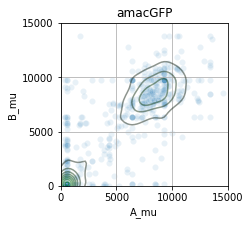

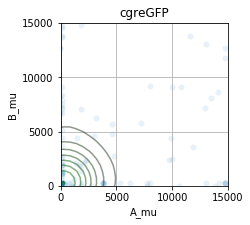

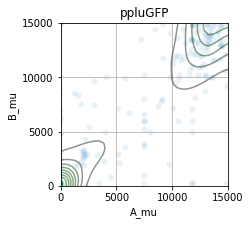

In [46]:
plt.close('all')
def regress_plot(dr,regress_result):
    plt.figure(figsize=(3,3),facecolor='w')
    d = dr.sample(20000)

    sns.kdeplot(d.A_mu*regress_result['slope']+regress_result['intercept'],d.B_mu,alpha=.5,color='g')
    ds = d.sample(500)
    sns.scatterplot(ds.A_mu*regress_result['slope']+regress_result['intercept'],ds.B_mu,alpha=.1)

    plt.xlim([0,15000])
    plt.ylim([0,15000])
    plt.xticks([0,5000,10000,15000])
    plt.yticks([0,5000,10000,15000])
    plt.grid()
    plt.title(regress_result['POI'])
regress_plot(d_amac_AB,amac_regress)
regress_plot(d_cgre_AB,cgre_regress)
regress_plot(d_pplu_AB,pplu_regress)


In [23]:
def mu_correct (d,regress_result):
    d['muc']=d.apply(lambda x: x.mu if x.machine=='B' else x.mu*regress_result['slope']+regress_result['intercept'],axis=1)
    return d

In [47]:
d_amac_c = mu_correct(d_amac.copy(),amac_regress)
d_cgre_c = mu_correct(d_cgre.copy(),cgre_regress)
d_pplu_c = mu_correct(d_pplu.copy(),pplu_regress)


In [55]:
start_ = datetime.today().strftime('%Y%m%d-%H%M%S')
d_amac_c.to_csv(f"amacGFP_cdf_fitting_mu_corrected_bw_AB_ByWTs_{start_}.csv.gz")
d_cgre_c.to_csv(f"cgreGFP_cdf_fitting_mu_corrected_bw_AB_ByWTs_{start_}.csv.gz")
d_pplu_c.to_csv(f"ppluGFP_cdf_fitting_mu_corrected_bw_AB_ByWTs_{start_}.csv.gz")